# Parallel TS Map computation documentation

## Term explanation

### Compton Data Space
Compton data space (CDS) is a 3D space contains three axes:
- Compton scattering angle
- Psi
- Chi

The CDS tells us how the photons are distributed regarding these three properties. For more information about CDS, please refer to the main documentation of data challenge 2.

### Measured data
Measured data is the direct measurements of photons from the detector. It includes both source and background photons. In reality, we cannot distinguish the source and background photons. Nevertheless, the data we use here are made from simulations so that we can separate them.

### Background model
The background model simply records the background counts at different energies. In reality, we will use specific background models for data analysis. However, we can obtain the true background counts in this tutorial notebook since the data are simulated, not measured.

### Response
The response is a file that records how the detector responds to (measures) the received photons. Because the photon measurement is not perfect, a 3-MeV photon might be measured as a 2.8-MeV photon (or other energy). Thus, the photons with the same true energy will be dispersed into different measured energy channels. This phenomenon is called energy dispersion. The energy dispersion can be derived from the detector response and represented as an energy dispersion (redistribution) matrix.
1. This is a graph of the energy redistribution matrix. The $x$ axis is the incident (true) energy, and the $y$ axis is the measured energy.<center>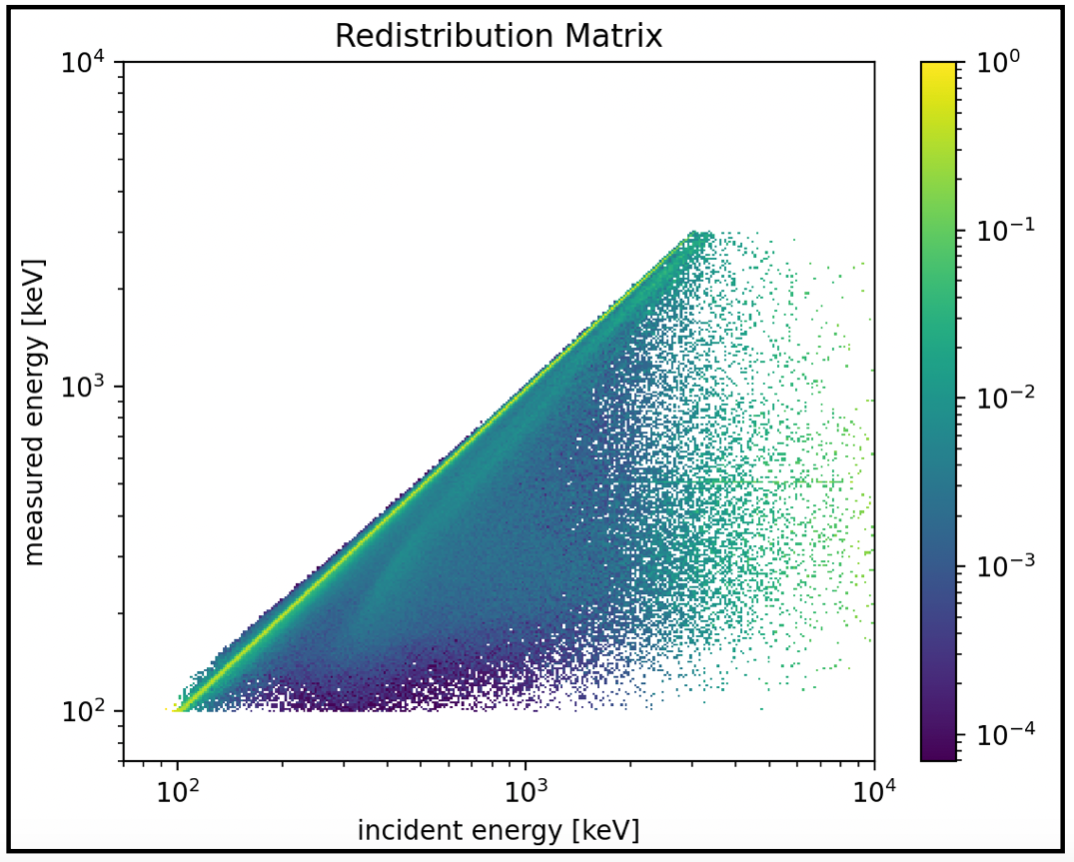</center>
2. If you take a vertical slice (same incident energy), you will see how the energy is dispersed into the measured energy channels.
3. Response contains more information than just energy. It can also hold distance, Compton scattering angle, etc. I just use energy to demonstrate what response is.

The response files are generated by very computationally intensive simulations since we need a massive amount of photons at different energies, incident energies, and other properties like polarization to gain a statistical result. 

In this notebook, we will use two types of responses:
- detector response  --> needed for data binned in local (Spacecraft) coordinates
- galactic response --> needed for data binned in galactic coordinates.

The galactic response is converted from the detector one.

## Fast flux and TS Map calculation

Unlike the IR and optical regime, the detector receives $\gamma$-ray photons one by one because of the low flux. This counting experiment makes Possion distribution the preferred statistical model to describe the $\gamma$-ray photons.

### Possion distribution
A discrete random variable $X$ is said to have Poisson distribution, with parameter $\lambda>0$:
$$
f(k;\lambda)=\text{Pr}(X=k)=\frac{\lambda^ke^{-\lambda}}{k!},
$$
where:
- $k$ is the number of occurrences ($k=0,1,2,...$)
- $e$ is the Euler's number
- $\lambda$ is equal to the expectation and variance of $X$: $\lambda=\text{E}(X)=\text{Var}(X)$

### Maximum Poisson log-likelihood ratio test statistic (TS)

Here, we will examine two contradictory hypotheses:
- There are non-background photons emitted from a sky location (pixel) with likelihood $L(f)$, where $f$ is the non-background flux.
- There are only background photons emitted from a sky location (pixel) with likelihood $L(0)$, where $f=0$ since no source is present.

The log-likelihood ratio test statistic is defined as:
$$
L L R(f)=2 \log \frac{L(f)}{L(0)}=2 \sum_{i=1}^N \log \frac{P\left(b_i+e_i f, d_i\right)}{P\left(b_i, d_i\right)}
$$
$$
T S=\max L L R(f)=L L R(F)
$$


- $P(\lambda, n)$ is the Poisson probability for n photons with mean $\lambda$ (also called expectation)
    - $\lambda=b_i+e_i f$
        - $b_i$ is the background counts
        - $e_i$ is the expected excess per flux unit obtained from the detector response
        - $f$ is the free parameter representing the flux from the source
    - $d_i$ is the measured count data, including both source and background photons
    - $F$ is the best estimated flux norm that maximizes $L L R(f)$

One good news is that $L L R(f)$ has analytic derivatives at all orders. What's more, the second-order derivative is always negative. Therefore, $L L R(f)$ has only one maximum, which can be solved by Newton-Raphson's method.
$$
L L R^{\prime}(f)=2 \sum\left(d_i \frac{e_i}{b_i+e_i f}-e_i\right)
$$
$$
L L R^{\prime \prime}(f)=-2 \sum\left(d_i \frac{e_i^2}{\left(b_i+e_i f\right)^2}\right)
$$

### Parallel Computation

The way we generate a TS map is to iterate through all pixels in an all-sky map. Although this generally works, it needs a tremendous amount of time when we want an all-sky map with a good resolution (3072 pixels or higher). A solution to speed it up is implementing parallel computation in our method. The idea is very simple: **The computation of pixels is independent of each other. Thus, we can perform the computations together, depending on the number of available CPU cores per user.**

Here let me describe the steps in the computation for a single pixel:

#### Step 1: Data Preparation

We need several data files to perform the TS map calculation
- <u>Measured (observational) data</u> in *hd5f* format
- <u>Background model</u> in *hd5f* format
- <u>Response</u> in *h5* format (we have both detector and galactic responses)
- <u>Orientation file</u> in *ori* format (needed when using detector response)
    
With those files, we can then:

- Read all the data files
- Generate a null all-sky map with a customized number of pixels
- Choose a pixel from the all-sky map
- Convolve the response with the pixel coordinate and spectrum to get the expected excess per flux unit $e_i$

#### Step 2: Data Projection
The data themselves have multiple axes. However, we only need Compton data space on a specific energy range. So, we will process the data to obtain the portion needed for the TS map.
- Slice the energy range we want
- Project to Compton data space (CDS).

    CDS is a 3D data space (Compton scattering angle, Psi, and Chi); here, I use a 2D slice (PsiChi) to represent CDS in the image below.

#### Steps 3: Newton-Raphson's Method
With the data we obtained from Step 2, we can construct the log-likelihood ratio function and find its global maximum. The returned maximum will be feedback to the pixel we picked as the TS value or the flux norm. At this point, the calculation of a pixel is completed.

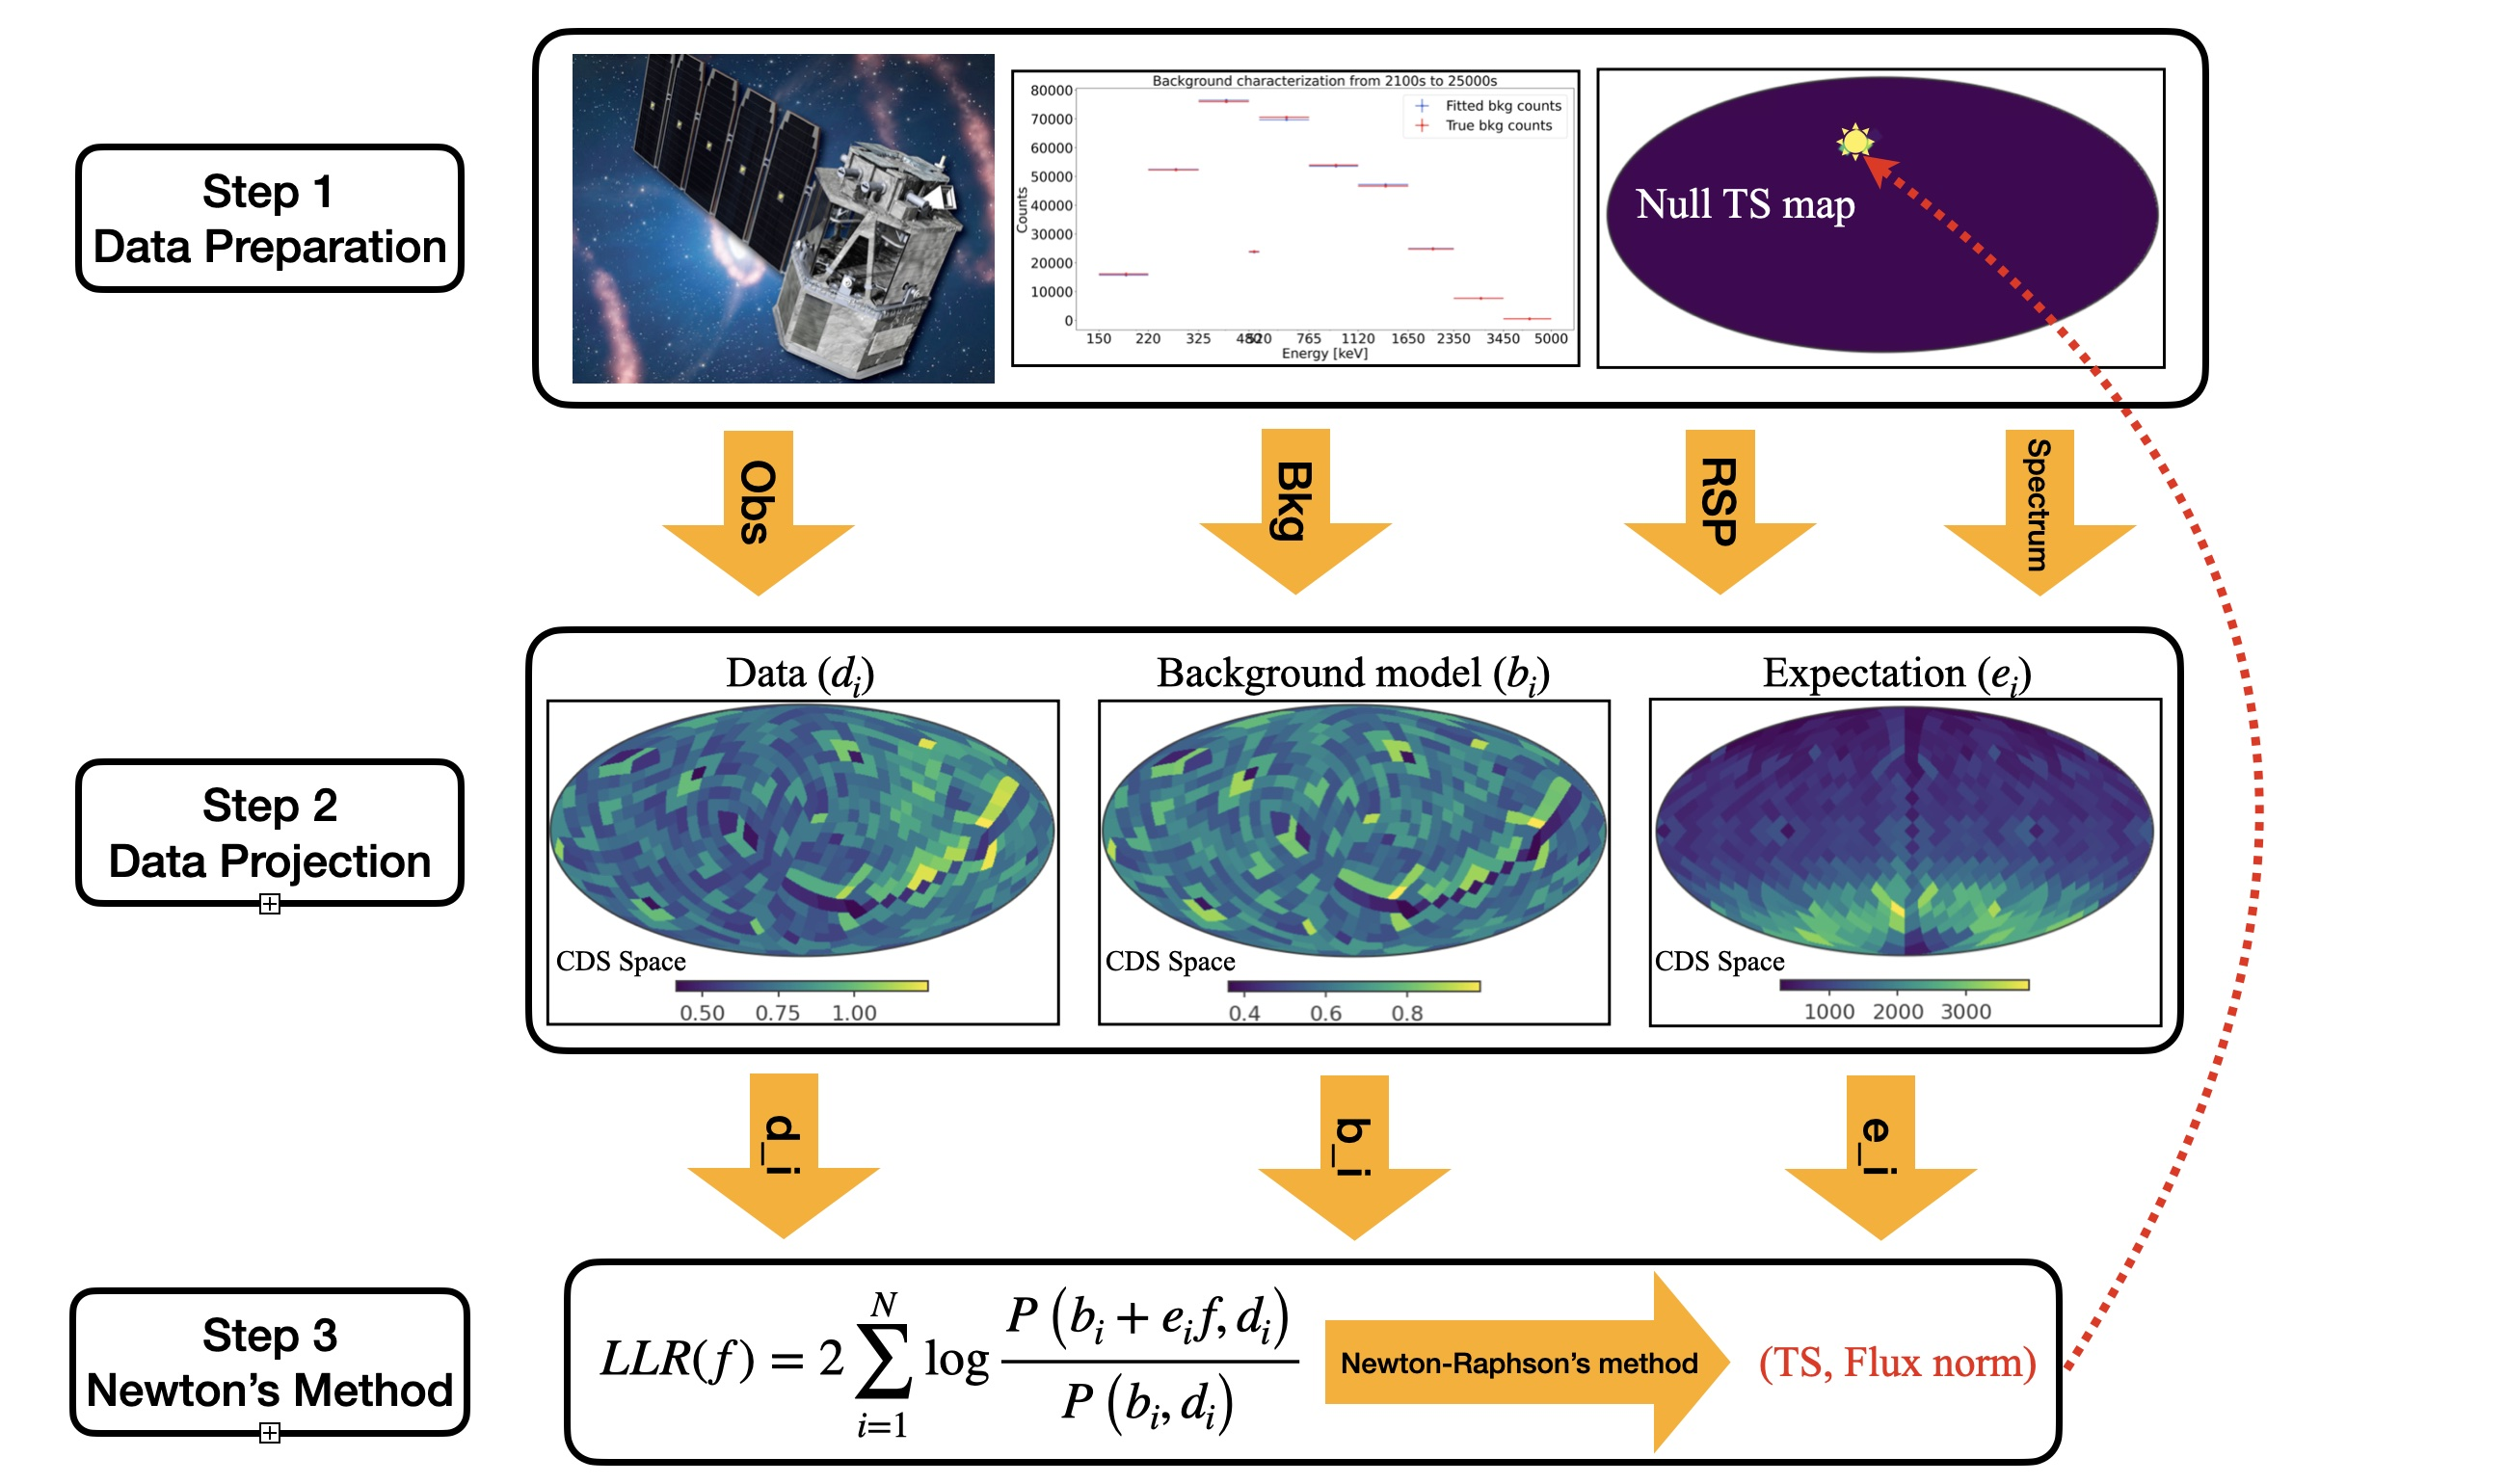

## Improvements in progress

The current method can generate the TS map for a GRB and Crab. However, the computation time needed on a personal laptop is still long and requires a massive amount of RAM (~30-40 GB). The future improvements will include:
- Optimization of the speed
    - Faster algorithm for Newton-Raphson's method
    - GPU computation
- Optimization of the RAM usage
    - Share memories among parallel processes

In [1]:
%%capture
# import necessary modules
from threeML import Powerlaw
from cosipy import FastTSMap, SpacecraftFile
from cosipy.response import FullDetectorResponse
import astropy.units as u
from histpy import Histogram
from astropy.time import Time
import numpy as np
from astropy.coordinates import SkyCoord
from pathlib import Path
from mhealpy import HealpixMap
from matplotlib import pyplot as plt
import sys

# Fit the GRB using the Compton Data Space (CDS) in local coordinates (Spacecraft frame)

## Define a powerlaw spectrum

In [2]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

## Read data, background model and orientation

In [3]:
# Read all the files needed

bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Bkg_2s_model.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

# We will use full signal counts now (100%). Note that the full signal is very very strong  GRB.
signal = 1*signal
data_used = bkg + signal

In [4]:
# Read GRB orientation from file
ori = SpacecraftFile.parse_from_file("../../cosipy/test_data/GRB_Orientation.ori")

## Start TS map fit

In [5]:
# define the path to the response
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/Continuum_Flat_100to10000keV_10logEbins_HealPix03.binnedimaging.imagingresponse_nside8.area.h5")

# here let's create a FastTSMap object for fitting the ts map in the following cells
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, cds_frame = "local", scheme = "RING")

In [6]:
# get a list of hypothesis coordinates to fit. The models will be put on these locations for get the expected counts from the source
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

Below is the actual parallel fit:
- In default, the maximum number of cores it can use is `max_number-1`. You can also customize the number of cores you want to use by the `cpu_cores` parameter.
- energy channel is `[lower_channel, upper_channel]`. Lower channel is inclusive while the upper channel is exclusive
- This might take long in a personal computer and consume a lot of memories (up to 30-40 GB)

In [7]:
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)

The time used for the parallel TS map computation is 2.9434447566668194 minutes


## Plot the fitted TS map

In [8]:
# This the true location of the GRB
coord = SkyCoord(l=51, b = -17, unit = (u.deg, u.deg), frame = "galactic")

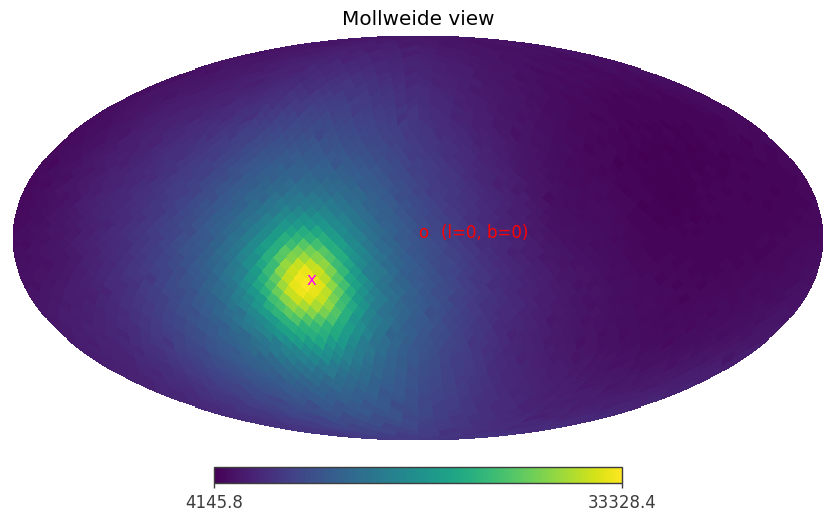

In [9]:
ts.plot_ts(skycoord = coord)

The image above plots the raw TS values, which is also an image of the GRB. However, for the purpose of localization, we are more interested in the confidence level of the imaged GRB. Thus, you can plot the 90% confidence level of the GRB location by setting `containment` parameter to the percetage you want to plot.

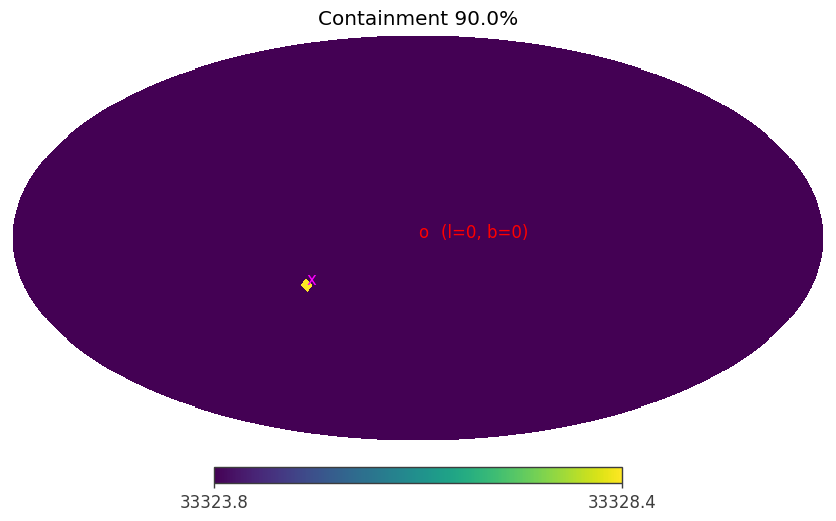

In [10]:
ts.plot_ts(skycoord = coord, containment = 0.9)

As you can see, the GRB region shrinks only to a single pixel. This is caused by the fact that the GRB signal is very very strong in this case. In the next section, we will manipulate the strength of the GRB signal to see how the front source signal affects the TS values and the 90% confidence region.

# Fit a fainter GRB using the Compton Data Space (CDS) in local coordinates (Spacecraft frame)

Here we will set up a scaling factor to manipulate the strength of the signal to see the affects on the final TS map. Since all the steps are exactly the same execpt the scaling factor, I will put the main codes in a single cell for simplicity.

**If you encounter any errors, please try to restart the notebook kernel or the whole session.**

In [9]:
scaling_factor = 0.02

In [10]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

# open bkg model
bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Bkg_2s_model.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

# We scale the signal here
signal = scaling_factor*signal
data_used = bkg + signal

# Read GRB orientation from file
ori = SpacecraftFile.parse_from_file("../../cosipy/test_data/GRB_Orientation.ori")

# define the path to the response
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/Continuum_Flat_100to10000keV_10logEbins_HealPix03.binnedimaging.imagingresponse_nside8.area.h5")

# here let's create a FastTSMap object for fitting the ts map in the following cells
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, cds_frame = "local", scheme = "RING")

# get a list of hypothesis coordinates to fit. The models will be put on these locations for get the expected counts from the source
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)


The time used for the parallel TS map computation is 2.9340662002563476 minutes


In [11]:
# This the true location of the GRB
coord = SkyCoord(l=51, b = -17, unit = (u.deg, u.deg), frame = "galactic")

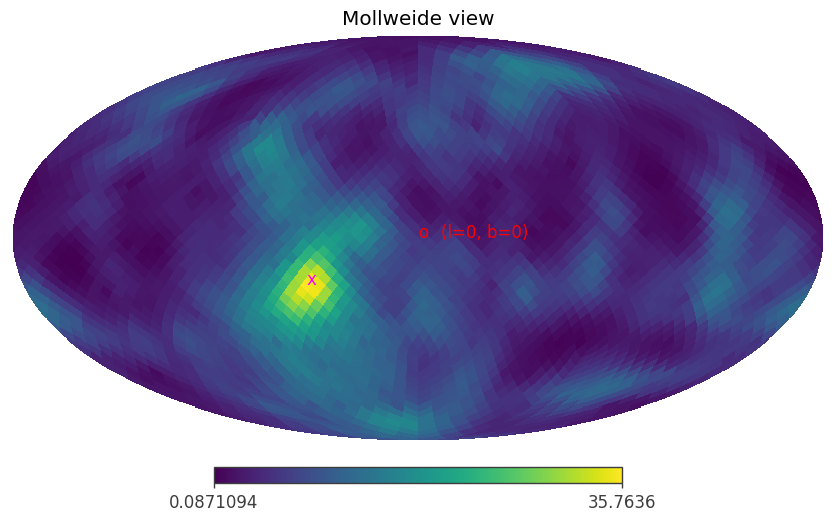

In [12]:
# plot the raw ts values
ts.plot_ts(skycoord = coord)

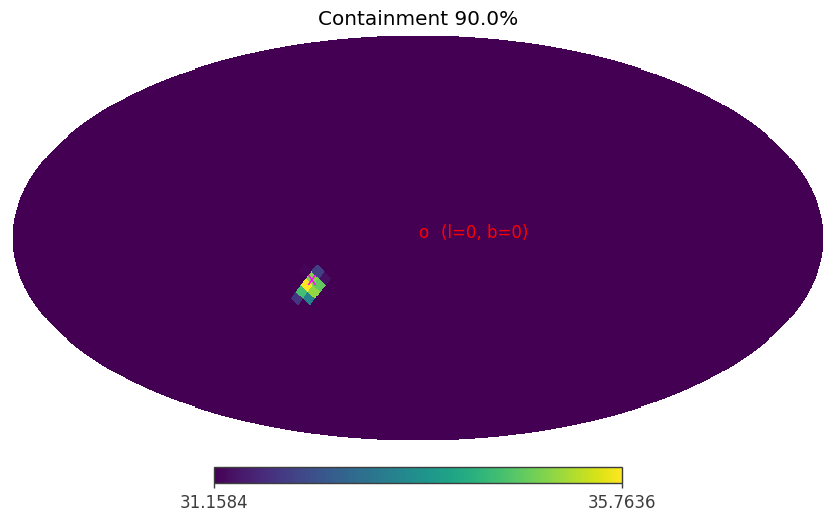

In [13]:
# plot the 90% confidence region
ts.plot_ts(skycoord = coord, containment = 0.9)

# Fit Crab using the Compton Data Space (CDS) in galactic coordinates

The Crab case is similar to the GRB one. The difference is that the Crab data (signal and background) are binned in the galactic coordiates instead of the spacecraft coordinates. Therefore, we will need to use the galatic response for Crab.

## Process data

In [2]:
# get the binned Crab data
# Because the binned Crab data is too large, so it can't be uploaded to GitHub.
# I've uploaded the binned data to wasabi at "COSI-SMEX/DC2/Data/Sources". If you have downloaded the binned data file from wasabi, please ignore this cell
# Here is the code I used to bin the Crab data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("../../cosipy/test_data/Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data="/home/sheng2/astrohe_yong/COSI/cosipy_workshop2023/DC2/Data/Sources/crab_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False,
                         output_name="Crab_galactic_CDS",
                         psichi_binning = "galactic")

# After you generate the binned data files, it should be saved to the same directory of this notebook

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [3]:
# get the binned background data
# Because the binned background data is too large, so it can't be uploaded to GitHub.
# I've uploaded the binned data to wasabi at "COSI-SMEX/DC2/Data/Backgrounds". If you have downloaded the binned data file from wasabi, please ignore this cell
# Here is the code I used to bin the background data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("../../cosipy/test_data/Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data="/home/sheng2/astrohe_yong/COSI/cosipy_workshop2023/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False,
                         output_name="Albedo_galactic_CDS",
                         psichi_binning = "galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [2]:
# Read background and signal data

bkg_model = Histogram.open("Albedo_galactic_CDS.hdf5")  # please make sure you adjust the path to the files by yourself.
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("Crab_galactic_CDS.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

# here the background added to the source is the same as the bkg model since they are simulations, thus we know the background very well.
bkg_original = Histogram.open("Albedo_galactic_CDS.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal 
data_used = bkg + signal

Text(0, 0.5, 'Counts')

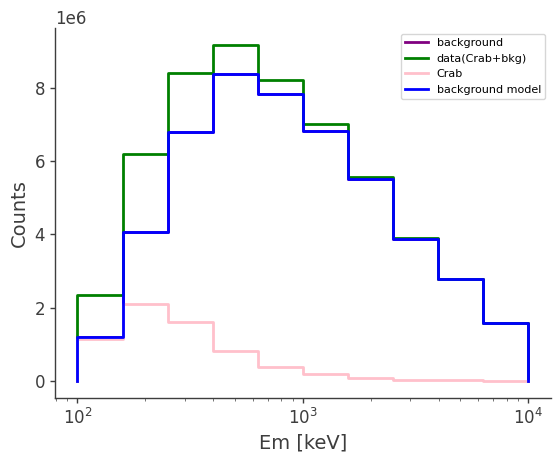

In [3]:
# plot the counts distribution
ax,plot = bkg.project("Em").draw(label = "background", color = "purple")
#data.project("Em").draw(ax, label = "data", color = "green")
data_used.project("Em").draw(ax, label = "data(Crab+bkg)", color = "green")
signal.project("Em").draw(ax, label = "Crab", color = "pink")
bkg_model.project("Em").draw(ax, label = "background model", color = "blue")

ax.legend()
ax.set_xscale("log")
ax.set_ylabel("Counts")

## Start TS map fit

In [4]:
# define a powerlaw spectrum
index = -3
K = 10**-3 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV

spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

In [5]:
# the galactic response file is available on wasabi
response_path = Path("/zfs/astrohe/yong/COSI/cosipy_workshop2023/DC2/Responses/PointSourceReponse/psr_gal_DC2.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, response_path = response_path, cds_frame = "galactic", scheme = "RING")

In [6]:
# get a list of hypothesis coordinates to fit. The models will be put on these locations for get the expected counts from the source
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [7]:
# Perform the parallel fit
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [1,2], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)

The time used for the parallel TS map computation is 0.5331416805585225 minutes


## Plot results

In [8]:
# This the true location of Crab
coord = SkyCoord(l=184.5551, b = -05.7877, unit = (u.deg, u.deg), frame = "galactic")

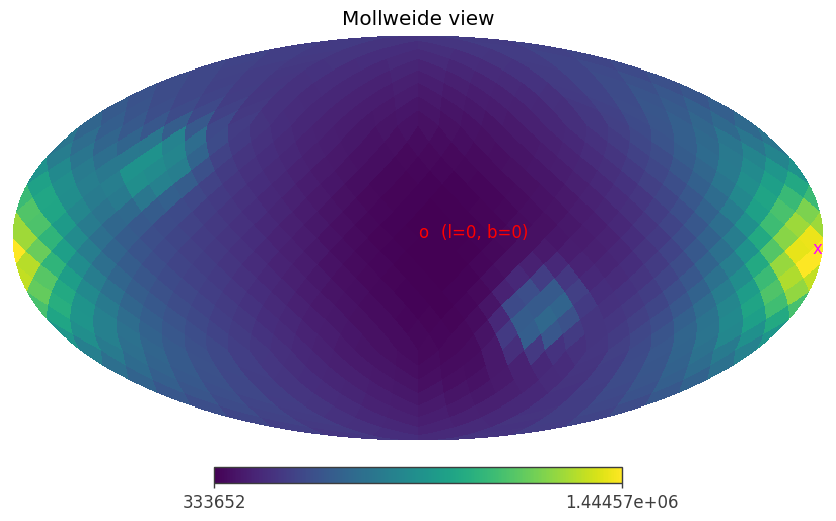

In [9]:
# plot the raw ts values
ts.plot_ts(skycoord = coord)

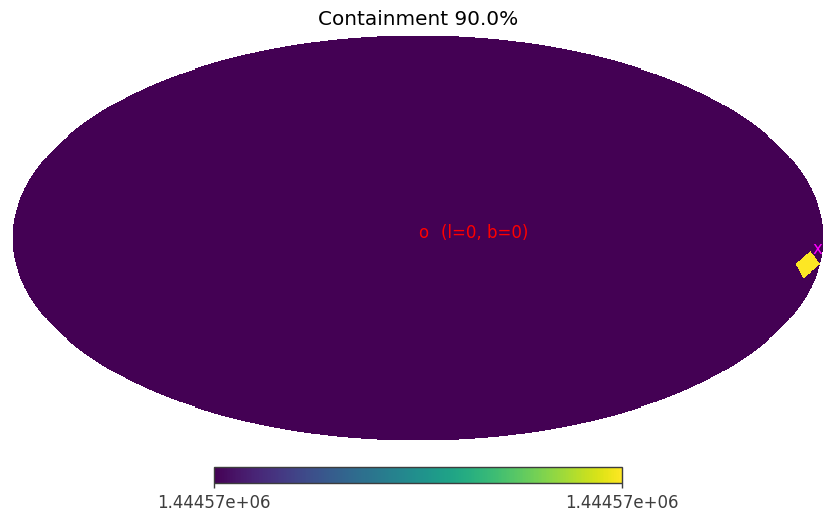

In [10]:
# plot the 90% confidence region
ts.plot_ts(skycoord = coord, containment = 0.9)